# Notebook Imports

In [1]:
from os import walk
from os.path import join

import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup
from wordcloud import WordCloud
from PIL import Image
import numpy as np

from sklearn.model_selection import train_test_split

%matplotlib inline

# Constants

In [2]:
# File paths (Updated to use only CSV dataset)
DATASET_PATH = "C:/Users/rachi/OneDrive/Desktop/spam.csv"

# Constants
SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE = 2500

# Loading the Data

In [3]:
df = pd.read_csv(DATASET_PATH, encoding='latin1')

# Drop rows with missing values
df.dropna(inplace=True)

# Display dataset info
print("Dataset loaded successfully.")
print(df.head())

Dataset loaded successfully.
   Category                                            Message
0         0  Go until jurong point, crazy.. Available only ...
1         0                      Ok lar... Joking wif u oni...
2         0  Free entry in 2 a wkly comp to win FA Cup fina...
3         0  U dun say so early hor... U c already then say...
4         1  Nah I don't think he goes to usf, he lives aro...


# Reading File

In [4]:
df = pd.read_csv(DATASET_PATH, encoding='latin1')

# Drop rows where 'Message' is missing
df = df.dropna(subset=['Message'])

# Check if there are valid messages
if not df.empty:
    email_body = df['Message'].iloc[0]  # Get the first available email body
    print(email_body)
else:
    print("Error: No valid email bodies found in the dataset.")

Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...


# Email Body Extraction

In [5]:
def email_body_generator(path): 
    
    for root, dirnames, filenames in walk(path):
        for file_name in filenames:
            
            filepath = join(root, file_name)
        
            stream = open(filepath, encoding='latin-1')

            is_body = False
            lines = []

            for line in stream: 
                if is_body:
                    lines.append(line)
                elif line =='\n':
                    is_body = True
            stream.close()

            email_body = '\n'.join(lines)

            yield file_name, email_body

In [6]:
def df_from_directory(path, classification):
    rows = []
    row_names = []
    
    for file_name, email_body in email_body_generator(path):
        rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
        row_names.append(file_name)
        
    return pd.DataFrame(rows, index = row_names)

In [7]:
df = pd.read_csv(DATASET_PATH, encoding='latin1')

# Ensure necessary columns exist
if 'Message' in df.columns and 'Category' in df.columns:
    # Separate spam and ham emails
    spam_emails = df[df['Category'] == 1]
    ham_emails = df[df['Category'] == 0]

    # Display first few spam emails
    print("Spam Emails:")
    print(spam_emails.head())

    # Display first few ham emails
    print("\nHam Emails:")
    print(ham_emails.head())

Spam Emails:
    Category                                            Message
4          1  Nah I don't think he goes to usf, he lives aro...
5          1  FreeMsg Hey there darling it's been 3 week's n...
8          1  WINNER!! As a valued network customer you have...
9          1  Had your mobile 11 months or more? U R entitle...
11         1  SIX chances to win CASH! From 100 to 20,000 po...

Ham Emails:
   Category                                            Message
0         0  Go until jurong point, crazy.. Available only ...
1         0                      Ok lar... Joking wif u oni...
2         0  Free entry in 2 a wkly comp to win FA Cup fina...
3         0  U dun say so early hor... U c already then say...
6         0  Even my brother is not like to speak with me. ...


In [8]:
spam_emails.shape

(1364, 2)

In [9]:
ham_emails.shape

(4208, 2)

In [10]:
data = pd.concat([spam_emails, ham_emails])
print('Shape of entire dataframe is ', data.shape)
data.head()

Shape of entire dataframe is  (5572, 2)


Category                                            Message
4          1  Nah I don't think he goes to usf, he lives aro...
5          1  FreeMsg Hey there darling it's been 3 week's n...
8          1  WINNER!! As a valued network customer you have...
9          1  Had your mobile 11 months or more? U R entitle...
11         1  SIX chances to win CASH! From 100 to 20,000 po...

In [11]:
data.tail()

Category                                            Message
5563         0                                Ard 6 like dat lor.
5564         0  Why don't you wait 'til at least wednesday to ...
5565         0                                       Huh y lei...
5568         0            Will ÃÂ¼ b going to esplanade fr home?
5570         0  The guy did some bitching but I acted like i'd...

# Data Cleaning: Checking for Missing Values

In [12]:
data['Message'].isnull().values.any()

np.False_

In [13]:
(data.Message.str.len()==0).any()

np.False_

In [14]:
empty_messages=(data['Message'].str.len()==0).sum()
print(int(empty_messages))

0


# Add Document IDs to Track Emails in Dataset

In [15]:
document_ids = range(0, len(data.index))
data['DOC_ID'] = document_ids

In [16]:
data['FILE_NAME'] = data.index
data.set_index('DOC_ID', inplace=True)
data.head()

Category                                            Message  FILE_NAME
DOC_ID                                                                        
0              1  Nah I don't think he goes to usf, he lives aro...          4
1              1  FreeMsg Hey there darling it's been 3 week's n...          5
2              1  WINNER!! As a valued network customer you have...          8
3              1  Had your mobile 11 months or more? U R entitle...          9
4              1  SIX chances to win CASH! From 100 to 20,000 po...         11

In [17]:
data.tail()

Category                                            Message  FILE_NAME
DOC_ID                                                                        
5567           0                                Ard 6 like dat lor.       5563
5568           0  Why don't you wait 'til at least wednesday to ...       5564
5569           0                                       Huh y lei...       5565
5570           0            Will ÃÂ¼ b going to esplanade fr home?       5568
5571           0  The guy did some bitching but I acted like i'd...       5570

# Number of Spam Messages Visualised (Charts)

In [18]:
amount_of_spam=data['Category'].value_counts().get(1,0)
amount_of_ham=data['Category'].value_counts().get(0,0)
print(f"Spam Emails: {amount_of_spam}")
print(f"Ham Emails: {amount_of_ham}")

Spam Emails: 1364
Ham Emails: 4208


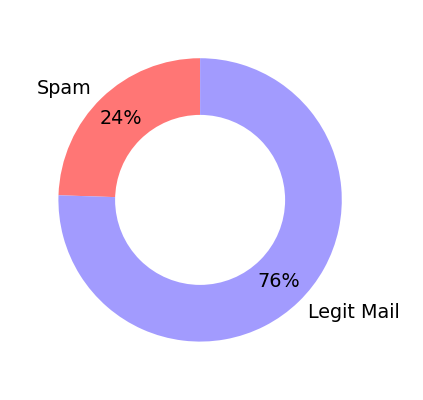

In [19]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]
custom_colors = ['#ff7675','#a29bfe']


plt.figure(figsize=(2,2), dpi = 230)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle = 90, autopct = '%1.0f%%', colors = custom_colors, pctdistance = 0.8)


#making a donut

centre_circle = plt.Circle((0,0), radius = 0.6, fc = 'white')
plt.gca().add_artist(centre_circle)

plt.show()

# Natural Language Processing

## Download the NLTK Resources (Tokenizer & Stopwords)

In [20]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rachi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [21]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rachi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [23]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from nltk.stem import PorterStemmer
import pandas as pd

# Ensure required NLTK packages are downloaded
nltk.download('punkt', force=True)  # Force re-download to fix errors
nltk.download('stopwords')

# Initialize stemmer and stopwords
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def clean_msg_no_html(message):
    if pd.isna(message) or not isinstance(message, str) or message.strip() == "":
        return ["empty"]  # Prevent empty lists

    soup = BeautifulSoup(str(message), 'html.parser')  
    cleaned_text = soup.get_text()
    
    try:
        words = word_tokenize(cleaned_text.lower())  
    except LookupError:
        words = cleaned_text.lower().split()

    filtered_words = [stemmer.stem(word) for word in words if word.isalpha() and len(word) > 1 and word not in stop_words]

    return filtered_words if filtered_words else ["empty"]  # Prevent empty lists

# Load dataset (assuming CSV format)
data = pd.read_csv("C:/Users/rachi/OneDrive/Desktop/spam.csv")  # Change file path as needed

# Check the available column names
print("Dataset Columns:", data.columns)

# Ensure correct column name for emails
email_column = "Message"  # Update if your column name is different

# Apply function to all emails while handling NaN values
data["Cleaned_Message"] = data[email_column].astype(str).fillna("").apply(clean_msg_no_html)

# Display first few cleaned emails
print(data[["Cleaned_Message"]].head())

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rachi\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rachi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Dataset Columns: Index(['Category', 'Message'], dtype='object')
                                     Cleaned_Message
0  [go, jurong, avail, bugi, great, world, la, ci...
1                                    [ok, joke, wif]
2  [free, entri, wkli, comp, win, fa, cup, final,...
3                         [dun, say, earli, alreadi]
4            [nah, think, goe, live, around, though]


# Apply Cleaning and Tokenization to all messages

## Slicing Dataframes and Series and Creating Subsets

In [24]:
%%time

nested_list=data.Message.apply(clean_msg_no_html)

CPU times: total: 7.44 s
Wall time: 13.4 s


In [25]:
nested_list.head()

0    [go, jurong, avail, bugi, great, world, la, ci...
1                                      [ok, joke, wif]
2    [free, entri, wkli, comp, win, fa, cup, final,...
3                           [dun, say, earli, alreadi]
4              [nah, think, goe, live, around, though]
Name: Message, dtype: object

In [26]:
nested_list.tail()

5567        [time, tri, contact, pound, claim, call, per]
5568                                   [go, esplanad, fr]
5569                                               [mood]
5570    [guy, bitch, act, like, interest, buy, someth,...
5571                                         [true, name]
Name: Message, dtype: object

# Using Logic to Slice Dataframes

In [27]:
doc_ids_spam=data[data["Category"]==1].index
doc_ids_ham=data[data["Category"]==0].index

# Subsetting a Series with an index

In [28]:
nested_list_ham=nested_list.loc[doc_ids_ham]

In [29]:
nested_list_ham.shape

(4208,)

In [30]:
nested_list_spam=nested_list.loc[doc_ids_spam]

In [31]:
nested_list_spam.shape

(1364,)

In [32]:
flat_list_ham = [item for sublist in nested_list_ham for item in sublist]
normal_words = pd.Series(flat_list_ham).value_counts()

normal_words.shape[0]

4232

In [33]:
normal_words[:10]

go      352
get     310
call    285
ur      241
come    226
like    199
got     192
know    191
want    188
good    162
Name: count, dtype: int64

In [34]:
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]
spammy_words = pd.Series(flat_list_spam).value_counts()

spammy_words.shape[0]

2295

In [35]:
spammy_words[:10]

call     338
free     153
ur       144
get      124
text     117
txt      114
repli     97
mobil     96
claim     91
send      87
Name: count, dtype: int64

# Word Cloud of Ham and Spam Messages

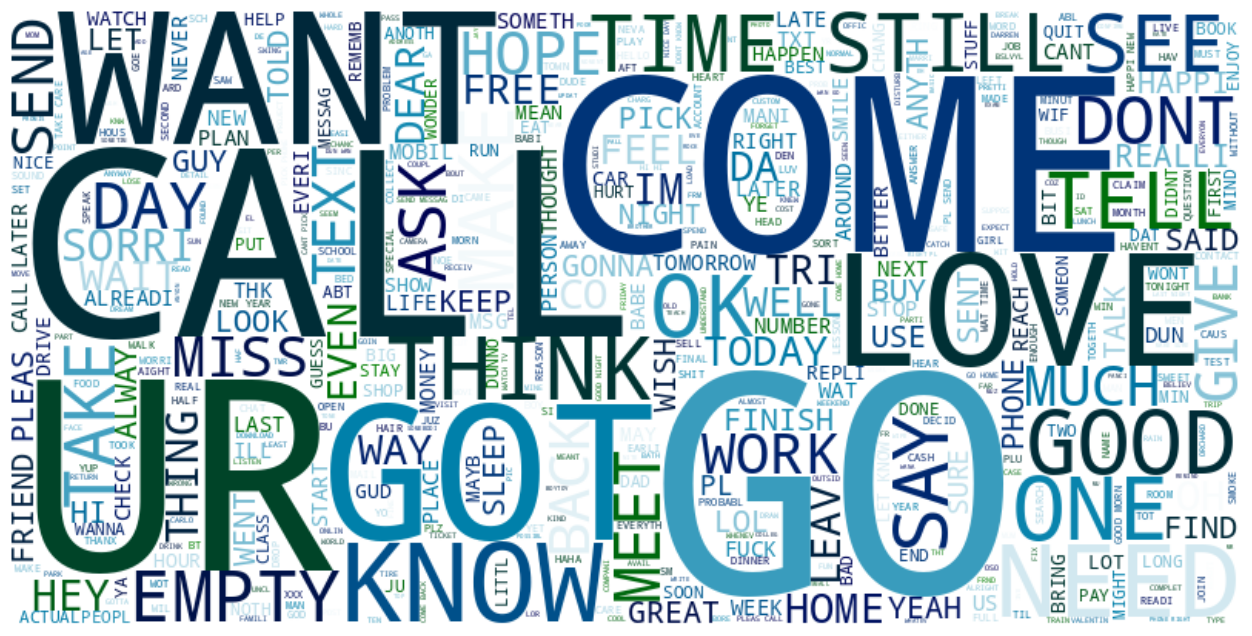

In [36]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# ✅ Generate text from ham messages
ham_str = ' '.join(flat_list_ham)

# ✅ Create a word cloud without a mask
word_cloud = WordCloud(
    background_color='white',
    max_words=500,
    colormap='ocean',
    max_font_size=200,
    width=800, height=400  # Define image size manually
)

word_cloud.generate(ham_str.upper())

# ✅ Display the word cloud
plt.figure(figsize=(16, 8))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

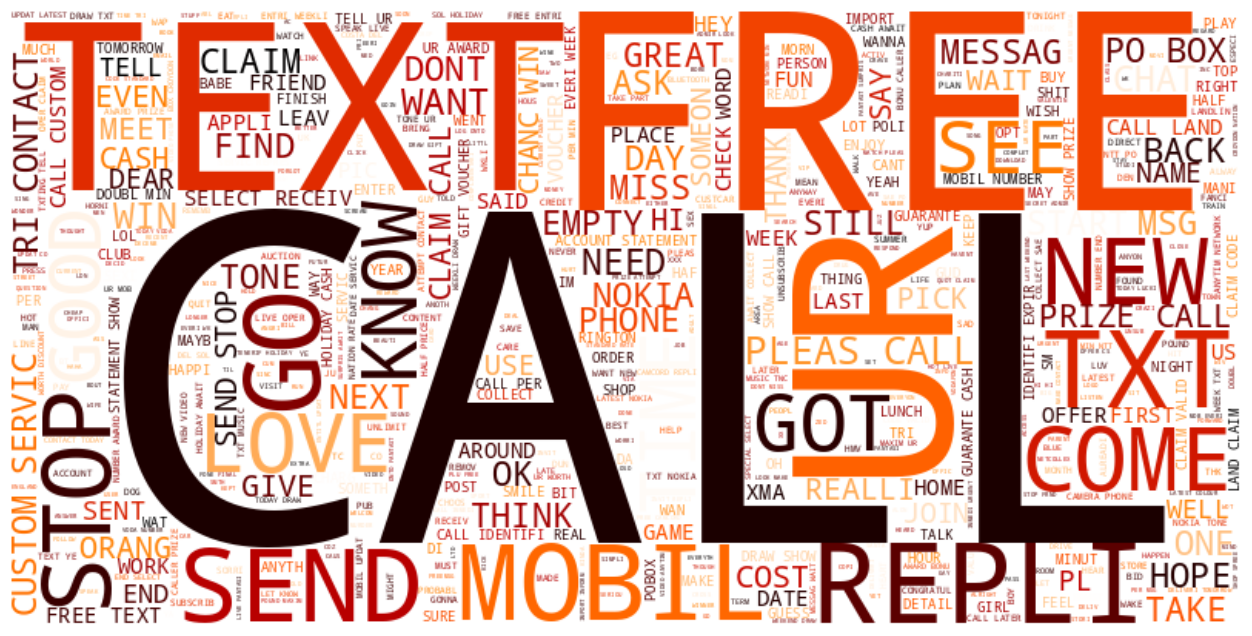

In [37]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# ✅ Generate text from spam messages
spam_str = ' '.join(flat_list_spam)

# ✅ Create a word cloud without a mask
word_cloud = WordCloud(
    background_color='white',
    max_words=2000,
    colormap='gist_heat',  # 🔥 Heatmap colors
    max_font_size=300,
    width=800, height=400  # Define manual size
)

word_cloud.generate(spam_str.upper())

# ✅ Display the word cloud
plt.figure(figsize=(16, 8))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Generate Vocabulary & Dictionary

In [42]:
stemmed_nested_list=data.Message.apply(clean_msg_no_html)
flat_stemmed_list=[item for sublist in stemmed_nested_list for item in sublist]

In [43]:
unique_words=pd.Series(flat_stemmed_list).value_counts()
print('Number if unique words', unique_words.shape[0])
unique_words.head()

Number if unique words 4961


call    623
get     434
go      426
ur      385
come    279
Name: count, dtype: int64

In [44]:
frequent_words=unique_words[0:VOCAB_SIZE]
print('Most common words: \n',frequent_words[:10])

Most common words: 
 call    623
get     434
go      426
ur      385
come    279
like    249
know    243
got     235
want    234
free    229
Name: count, dtype: int64


# Create Vocabulary DataFrame with a WORD_ID

In [47]:
word_ids=list(range(0,VOCAB_SIZE))
vocab=pd.DataFrame({'VOCAB_WORD': frequent_words.index.values},index=word_ids)
vocab.index.name='WORD_ID'
vocab.head()

VOCAB_WORD
WORD_ID           
0             call
1              get
2               go
3               ur
4             come

# Generate Features and a Sparse Matrix

## Creating a Dataframe with one word per column

In [49]:
word_columns_df=pd.DataFrame.from_records(stemmed_nested_list.tolist())
word_columns_df.head()

0       1      2        3       4       5     6      7     8     9   ...  \
0    go  jurong  avail     bugi   great   world    la   cine   got  amor  ...   
1    ok    joke    wif     None    None    None  None   None  None  None  ...   
2  free   entri   wkli     comp     win      fa   cup  final   tkt   may  ...   
3   dun     say  earli  alreadi    None    None  None   None  None  None  ...   
4   nah   think    goe     live  around  though  None   None  None  None  ...   

     50    51    52    53    54    55    56    57    58    59  
0  None  None  None  None  None  None  None  None  None  None  
1  None  None  None  None  None  None  None  None  None  None  
2  None  None  None  None  None  None  None  None  None  None  
3  None  None  None  None  None  None  None  None  None  None  
4  None  None  None  None  None  None  None  None  None  None  

[5 rows x 60 columns]

In [50]:
word_columns_df.shape

(5572, 60)

# Splitting the Data into Training and Testing Dataset

In [51]:
X_train, X_test, y_train, y_test = train_test_split(word_columns_df, data["Category"], test_size=0.3, random_state=42)

In [52]:
print('Number of training samples:', X_train.shape[0])
print('Fraction of training set:', X_train.shape[0]/word_columns_df.shape[0 ])

Number of training samples: 3900
Fraction of training set: 0.6999282124910265


In [53]:
X_train.index.name = X_test.index.name = 'DOC_ID'
X_train.head()

0      1       2       3       4     5     6     7     8     9   \
DOC_ID                                                                         
708        quit   late     ard  anyway     wun  None  None  None  None  None   
4338    tuesday  night    real    None    None  None  None  None  None  None   
5029         go  chase     run   cross  street  None  None  None  None  None   
4921        say  never  answer    None    None  None  None  None  None  None   
2592      still   work      go   small    None  None  None  None  None  None   

        ...    50    51    52    53    54    55    56    57    58    59  
DOC_ID  ...                                                              
708     ...  None  None  None  None  None  None  None  None  None  None  
4338    ...  None  None  None  None  None  None  None  None  None  None  
5029    ...  None  None  None  None  None  None  None  None  None  None  
4921    ...  None  None  None  None  None  None  None  None  None  None  
2592    ...  None  None  None  None  None  None  None  None  None  None  

[5 rows x 60 columns]

In [54]:
y_train.head()

708     0
4338    0
5029    1
4921    0
2592    0
Name: Category, dtype: int64

# Create a Sparse Matrix for the Training Data

In [55]:
word_index = pd.Index(vocab.VOCAB_WORD)
from scipy.sparse import coo_matrix

def make_sparse_matrix(df, indexed_words, labels):
    """
    Returns a DataFrame in the format: LABEL, DOC_ID, OCCURRENCE, WORD_ID.
    
    df: A DataFrame with words in columns and document IDs as index (X_train or X_test)
    indexed_words: Index of words ordered by word ID
    labels: Category as a Series (y_train or y_test)
    """
    
    word_set = set(indexed_words)
    
    # Identify positions where words exist in vocab
    mask = df.map(lambda x: x in word_set)
    doc_ids, word_texts = np.where(mask.values)  # Get row & column indices
    
    # Get corresponding words
    words_found = df.values[doc_ids, word_texts]
    
    # Convert words to word indices
    word_ids = [indexed_words.get_loc(word) for word in words_found]
    
    # Map row indices to actual document IDs
    doc_indices = df.index[doc_ids]  # These should match X_train.index
    
    # Ensure labels align with doc_indices
    labels_mapped = labels.reindex(doc_indices).values  # Safe mapping
    
    # Create DataFrame with the expected columns
    sparse_df = pd.DataFrame({
        "LABEL": labels_mapped,
        "DOC_ID": doc_indices,
        "OCCURENCE": 1,  # Each word appears once per row
        "WORD_ID": word_ids
    })

    return sparse_df

In [56]:
%%time
sparse_train_df=make_sparse_matrix(X_train,word_index,y_train)

CPU times: total: 93.8 ms
Wall time: 196 ms


In [57]:
sparse_train_df[:5]

LABEL  DOC_ID  OCCURENCE  WORD_ID
0      0     708          1      181
1      0     708          1      153
2      0     708          1      352
3      0     708          1      349
4      0     708          1      811

In [58]:
sparse_train_df.shape

(22783, 4)

In [59]:
sparse_train_df[-5:]

LABEL  DOC_ID  OCCURENCE  WORD_ID
22778      1    5390          1      125
22779      0     860          1       31
22780      0     860          1      580
22781      0     860          1      161
22782      0     860          1      692

# Combine Occurences with the Pandas groupby() Method

In [60]:
train_grouped = sparse_train_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()
train_grouped.head()

OCCURENCE
DOC_ID WORD_ID LABEL           
0      2       0              1
       7       0              1
       58      0              1
       273     0              1
       459     0              1

In [61]:
vocab.at[0,'VOCAB_WORD']

'call'

In [62]:
train_grouped = train_grouped.reset_index()
train_grouped.head() 

DOC_ID  WORD_ID  LABEL  OCCURENCE
0       0        2      0          1
1       0        7      0          1
2       0       58      0          1
3       0      273      0          1
4       0      459      0          1

In [63]:
train_grouped.tail()

DOC_ID  WORD_ID  LABEL  OCCURENCE
21761    5570      898      0          1
21762    5570     1043      0          1
21763    5570     1695      0          1
21764    5571      161      1          1
21765    5571      482      1          1

In [64]:
vocab.at[1908,'VOCAB_WORD']

'lv'

In [66]:
data.Message[2011]

'Dunno lei... I thk mum lazy to go out... I neva ask her yet...'

In [68]:
train_grouped.shape

(21766, 4)

In [70]:
TRAINING_DATA_FILE="train-data1.txt"
np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt='%d')

# Create a Sparse Matrix for the Test Data

In [71]:
X_test.head()

0      1        2      3      4       5      6       7     8   \
DOC_ID                                                                        
3245    christma    lik  frndshp    den    hug     get  peopl    hate  None   
944         also  sorta    blown  coupl   time  recent     id  rather  text   
1044         mmm   that   better    got  roast  better  drink    good  None   
2484          mm  kanji     dont    eat  anyth   heavi     ok    None  None   
812         ring   come      guy   gift  futur    hint   hint    None  None   

          9   ...    50    51    52    53    54    55    56    57    58    59  
DOC_ID        ...                                                              
3245    None  ...  None  None  None  None  None  None  None  None  None  None  
944     blue  ...  None  None  None  None  None  None  None  None  None  None  
1044    None  ...  None  None  None  None  None  None  None  None  None  None  
2484    None  ...  None  None  None  None  None  None  None  None  None  None  
812     None  ...  None  None  None  None  None  None  None  None  None  None  

[5 rows x 60 columns]

In [72]:
y_test.head()

3245    0
944     0
1044    1
2484    0
812     0
Name: Category, dtype: int64

In [73]:
X_test.shape

(1672, 60)

In [74]:
%%time

sparse_test_df=make_sparse_matrix(X_test,word_index,y_test)

CPU times: total: 62.5 ms
Wall time: 64.2 ms


In [75]:
sparse_test_df.shape

(9604, 4)

In [76]:
test_grouped = sparse_test_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum().reset_index()
test_grouped.head()

DOC_ID  WORD_ID  LABEL  OCCURENCE
0       8        0      1          1
1       8       45      1          2
2       8      110      1          1
3       8      127      1          1
4       8      149      1          1

In [77]:
test_grouped.shape

(9159, 4)

In [78]:
TEST_DATA_FILE="test-data1.txt"
np.savetxt(TEST_DATA_FILE, test_grouped, fmt = '%d')